## 1 Data Collection and Preparation


In [2]:
import pandas as pd
from fredapi import Fred

# Initialize Fred API
fred = Fred(api_key='121aa3d574f47586d48ca94b632f6805')

# Fetch data
gdp_growth = fred.get_series('A191RL1Q225SBEA')
inflation_rate = fred.get_series('CPIAUCSL')
unemployment_rate = fred.get_series('UNRATE')

# Prepare DataFrame
data = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation_Rate': inflation_rate.pct_change()*100,
    'Unemployment_Rate': unemployment_rate
})

# Resample to quarterly and handle missing values
data = data.resample('QE').mean().dropna()

## 2 Exploratory Data Analysis


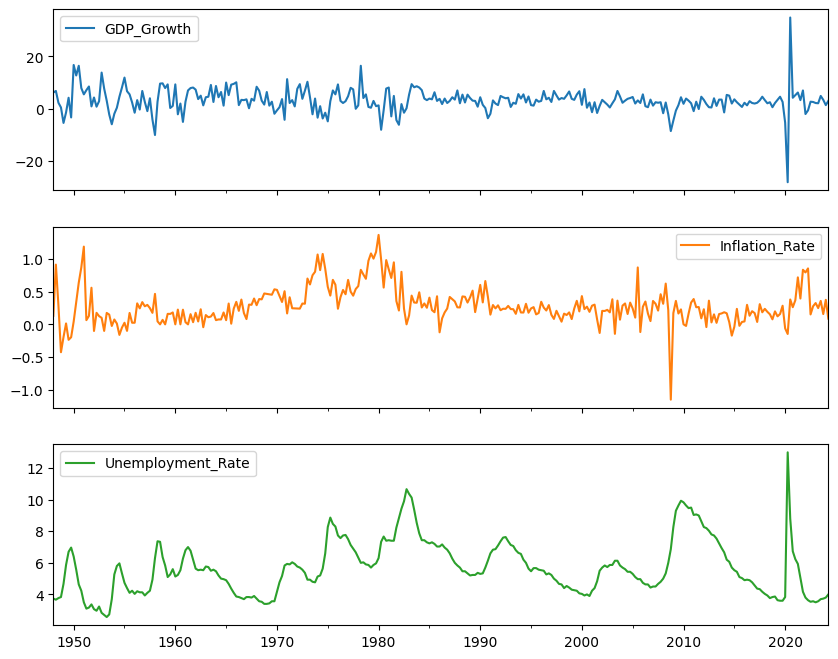

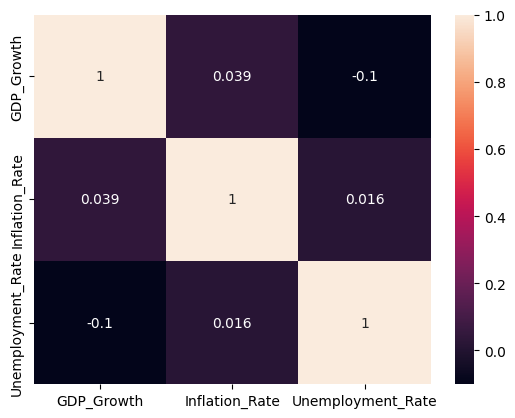

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series plots
data.plot(subplots=True, figsize=(10, 8))
plt.show()

# Correlation matrix
sns.heatmap(data.corr(), annot=True)
plt.show()

## 3 Testing for Stationarity

VAR models require stationary time series. We perform Augmented Dickey-Fuller (ADF) tests to check stationarity.


### 3.1 ADF Test


In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')

# Perform ADF tests
adf_test(data['GDP_Growth'], 'GDP Growth')
adf_test(data['Inflation_Rate'], 'Inflation Rate')
adf_test(data['Unemployment_Rate'], 'Unemployment Rate')

#If the series are non-stationary, differencing transforms them into stationary series suitable for VAR.
'''
data_diff = data.diff().dropna()

# Re-test for stationarity
adf_test(data_diff['GDP_Growth'], 'GDP Growth Differenced')
adf_test(data_diff['Inflation_Rate'], 'Inflation Rate Differenced')
adf_test(data_diff['Unemployment_Rate'], 'Unemployment Rate Differenced')
'''

ADF Statistic for GDP Growth: -15.249125675746596
p-value: 5.037916062616795e-28
ADF Statistic for Inflation Rate: -4.458885090752787
p-value: 0.00023315840753908177
ADF Statistic for Unemployment Rate: -3.6906920859975383
p-value: 0.004245999578298361


"\ndata_diff = data.diff().dropna()\n\n# Re-test for stationarity\nadf_test(data_diff['GDP_Growth'], 'GDP Growth Differenced')\nadf_test(data_diff['Inflation_Rate'], 'Inflation Rate Differenced')\nadf_test(data_diff['Unemployment_Rate'], 'Unemployment Rate Differenced')\n"

In the ADF test, the null hypothesis (H_0) is that the time series has a unit root (i.e., it is non-stationary). The alternative hypothesis (H_1) is that the series is stationary.

Since the p-values for all three series are less than the typical significance level of 0.05, you can reject the null hypothesis for each series:

- GDP Growth: The p-value is effectively zero, indicating strong evidence against the null hypothesis.
- Inflation Rate: The p-value is 0.000233, well below 0.05.
- Unemployment Rate: The p-value is 0.004246, also below 0.05.

Conclusion:

All three time series are stationary, meaning they do not require differencing or other transformations to achieve stationarity.


### 3.2 KPSS Test


In [5]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), **kw)
    print(f'KPSS Statistic: {statistic}, p-value: {p_value}')

kpss_test(data['GDP_Growth'])
kpss_test(data['Inflation_Rate'])
kpss_test(data['Unemployment_Rate'])

KPSS Statistic: 0.5123740811181763, p-value: 0.03887971145987021
KPSS Statistic: 0.3200301079900464, p-value: 0.1
KPSS Statistic: 0.2951656427209626, p-value: 0.1


/tmp/ipykernel_8291/834434606.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), **kw)
/tmp/ipykernel_8291/834434606.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series.dropna(), **kw)


GDP Growth:

- p-value = 0.03888 is less than 0.05.
- We reject the null hypothesis of stationarity.
- Conclusion: The series is non-stationary.

Inflation Rate and Unemployment Rate:

- p-values >= 0.1 (and possibly higher due to the warning).
- We fail to reject the null hypothesis of stationarity.
- Conclusion: The series are stationary.


### 3.3 Phillips Perron Test


In [6]:
from arch.unitroot import PhillipsPerron

def pp_test(series):
    pp = PhillipsPerron(series)
    print(pp.summary().as_text())

pp_test(data['GDP_Growth'])
pp_test(data['Inflation_Rate'])
pp_test(data['Unemployment_Rate'])

     Phillips-Perron Test (Z-tau)    
Test Statistic                -15.191
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -11.211
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.701
P-value                         0.004
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Nu

The PP test modifies the test statistics to account for serial correlation and heteroskedasticity in the error terms without adding lagged difference terms.

- Conclusion: Reject the null hypothesis of a unit root.
- Result: All three series are stationary.


### 3.4 Zivot Andrews Test


In [7]:
from statsmodels.tsa.stattools import zivot_andrews

def za_test(series, **kw):
    statistic, p_value, cvdict, baselag, bpidx = zivot_andrews(series.dropna(), **kw)
    print(f'ZA Statistic: {statistic}, p-value: {p_value}, critical values: {cvdict}, best lag: {baselag}, break point index: {bpidx}')

za_test(data['GDP_Growth'])
za_test(data['Inflation_Rate'])
za_test(data['Unemployment_Rate'])

ZA Statistic: -15.595534150826195, p-value: 1e-05, critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}, best lag: 0, break point index: 139
ZA Statistic: -5.614184120864695, p-value: 0.002694419085919662, critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}, best lag: 2, break point index: 76
ZA Statistic: -4.324435905274828, p-value: 0.18148916381438732, critical values: {'1%': -5.27644, '5%': -4.81067, '10%': -4.56618}, best lag: 0, break point index: 87


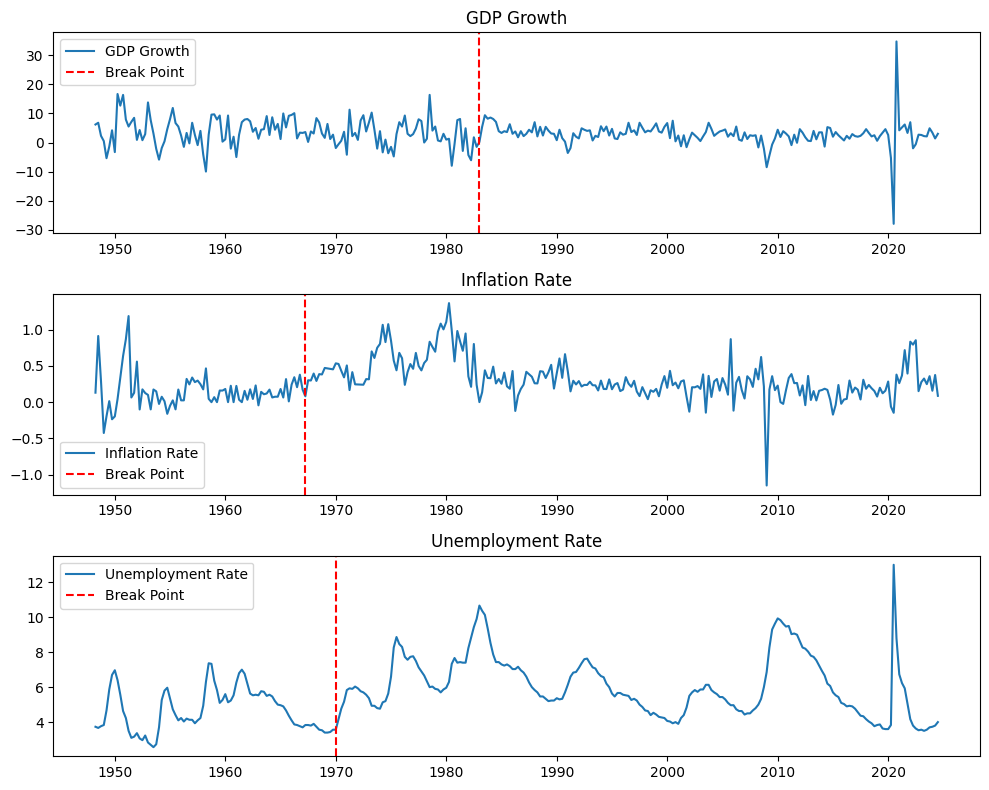

In [9]:
# Plot with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# First subplot: GDP Growth with break point
axes[0].plot(data.index, data['GDP_Growth'], label='GDP Growth')
axes[0].axvline(data.index[139], color='r', linestyle='--', label='Break Point')
axes[0].set_title('GDP Growth')
axes[0].legend()

# Second subplot: Inflation Rate with break point
axes[1].plot(data.index, data['Inflation_Rate'], label='Inflation Rate')
axes[1].axvline(data.index[76], color='r', linestyle='--', label='Break Point')
axes[1].set_title('Inflation Rate')
axes[1].legend()

# Third subplot: Unemployment Rate
axes[2].plot(data.index, data['Unemployment_Rate'], label='Unemployment Rate')
axes[2].axvline(data.index[87], color='r', linestyle='--', label='Break Point')
axes[2].set_title('Unemployment Rate')
axes[2].legend()

plt.tight_layout()
plt.show()

1. GDP Growth

- Conclusion: We reject the null hypothesis at the 1% significance level.
- Implication: The GDP Growth series is stationary with a structural break at index 139.

2. Inflation Rate

- Conclusion: We reject the null hypothesis at the 1% significance level.
- Implication: The Inflation Rate series is stationary with a structural break at index 76.

3. Unemployment Rate

- Conclusion: We fail to reject the null hypothesis.
- Implication: The Unemployment Rate series is non-stationary, even when allowing for a structural break.


### 3.5 Johansen Cointegration Test


In [48]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johansen_test = coint_johansen(data[['GDP_Growth', 'Inflation_Rate', 'Unemployment_Rate']], det_order=0, k_ar_diff=1)
print(johansen_test.lr1)  # Trace statistic

[196.52183257  56.35586853  13.02743853]


The Johansen Cointegration Test suggests that all possible cointegrating relationships are significant.

Implications

- Cointegration: The variables are cointegrated, indicating long-term equilibrium relationships among them.
- Action: Use a Vector Error Correction Model (VECM) instead of a standard VAR model to capture both short-term dynamics and long-term relationships.


#### Interpreting the Overall Evidence

- Majority of Tests (ADF, PP, Zivot-Andrews) suggest the series are stationary.
- KPSS Test suggests that GDP Growth is non-stationary.
- Economic Theory:
  - GDP growth rates are often considered stationary in macroeconomic theory.
  - Inflation rates and unemployment rates are also typically treated as stationary variables.


## 4 Estimating the Model


In [15]:
from statsmodels.tsa.api import VAR

# Initialize the VAR model
model = VAR(data)

# Select the optimal lag order
lag_order_results = model.select_order(maxlags=12)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.435       1.473       4.199       1.450
1       -1.638      -1.487      0.1944      -1.578
2       -1.852     -1.589*      0.1570      -1.746
3      -1.910*      -1.534     0.1481*     -1.759*
4       -1.877      -1.389      0.1530      -1.682
5       -1.857      -1.255      0.1563      -1.616
6       -1.810      -1.096      0.1638      -1.524
7       -1.787     -0.9602      0.1676      -1.456
8       -1.812     -0.8728      0.1635      -1.436
9       -1.776     -0.7231      0.1697      -1.354
10      -1.761     -0.5962      0.1722      -1.295
11      -1.742     -0.4644      0.1757      -1.231
12      -1.696     -0.3052      0.1842      -1.139
--------------------------------------------------


- AIC and FPE: Both criteria suggest that the optimal lag length is 3, as indicated by the minimum values at lag 3.
- BIC: Suggests an optimal lag length of 2.
- HQIC: Also suggests that the optimal lag length is 3.

Given that AIC, FPE, and HQIC all suggest a lag length of 3, and considering that these criteria are generally more suitable for model selection in VAR due to their tendency to favor models with better in-sample fit, it’s reasonable to proceed with a lag length of 3.


In [18]:
# Fit the VAR model
optimal_lag = 3
var_model = model.fit(optimal_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Sep, 2024
Time:                     21:48:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.39975
Nobs:                     303.000    HQIC:                  -1.62034
Log likelihood:          -992.047    FPE:                   0.170781
AIC:                     -1.76744    Det(Omega_mle):        0.154930
--------------------------------------------------------------------
Results for equation GDP_Growth
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -1.741242         1.021104           -1.705           0.088
L1.GDP_Growth                0.441174         0.079194            5.571           0.000
L1.Inflation_Rate          

GDP_Growth Equation:

Significant Variables (p < 0.05):

- L1.GDP_Growth: Positive and significant; current GDP growth is positively influenced by its first lag.
- L1.Unemployment_Rate: Positive and significant; current GDP growth is positively influenced by the first lag of unemployment rate.
- L2.GDP_Growth: Positive and significant; second lag of GDP growth has a positive effect.
- L2.Unemployment_Rate: Negative and significant; second lag of unemployment rate negatively affects GDP growth.

Variables with Marginal Significance:

- L2.Inflation_Rate: Negative coefficient with p-value of 0.075; suggests a possible negative effect on GDP growth.


Inflation_Rate Equation:

Significant Variables (p < 0.05):

- L1.Inflation_Rate: Positive and significant; inflation rate is strongly influenced by its first lag.
- L2.Inflation_Rate: Positive and significant; second lag also affects current inflation.
- L3.Inflation_Rate: Positive and significant; third lag has a significant effect.

Variables with Marginal Significance:

- L1.GDP_Growth: p-value of 0.095; suggests a possible positive effect on inflation.
- L3.GDP_Growth: p-value of 0.090; may indicate a delayed effect of GDP growth on inflation.


Unemployment_Rate Equation:

Significant Variables (p < 0.05):

- L1.GDP_Growth: Negative and significant; higher past GDP growth reduces current unemployment.
- L1.Unemployment_Rate: Positive and significant; unemployment rate is influenced by its own past values.
- L2.GDP_Growth: Negative and significant; the second lag of GDP growth also reduces unemployment.
- L2.Unemployment_Rate: Positive and significant; second lag has a positive effect.

Variables with Non-significant Coefficients:

- Inflation_Rate lags: Not significant, suggesting limited direct impact on unemployment in the short term.


Correlation Matrix of Residuals

- GDP_Growth and Unemployment_Rate: Strong negative correlation (-0.6736) in residuals, indicating that even after modeling, there is an inverse relationship.
- GDP_Growth and Inflation_Rate: Weak positive correlation (0.1433).
- Inflation_Rate and Unemployment_Rate: Weak negative correlation (-0.1307).


Key Findings

GDP_Growth Equation:

- Persistence: GDP growth is influenced by its own past values (lags 1 and 2), indicating persistence over time.
- Unemployment Rate Impact:
  - Positive Effect (L1): The first lag of unemployment rate positively affects GDP growth, which may seem counterintuitive.
  - Negative Effect (L2): The second lag has a negative effect, aligning with economic expectations.
- Inflation Rate Impact: Generally not significant, suggesting limited immediate impact on GDP growth.

Inflation_Rate Equation:

- Strong Autocorrelation: Inflation rate is heavily influenced by its own lags (1, 2, and 3).
- GDP_Growth Impact: Some evidence of GDP growth affecting inflation, but significance is marginal.

Unemployment_Rate Equation:

- Negative Relationship with GDP Growth: Consistent with economic theory (Okun’s Law), higher GDP growth reduces unemployment.
- Persistence in Unemployment: Unemployment rate is influenced by its own past values (lags 1 and 2).

Model Adequacy
- Significance of Coefficients: Many coefficients are statistically significant, indicating that the model captures important relationships.
- Residual Correlation: The residuals’ correlation suggests that the model may not fully account for all dynamics, especially between GDP growth and unemployment rate.


## 5 Diagnostics and Validation


In [14]:
# Residual analysis
from statsmodels.stats.diagnostic import acorr_ljungbox

# For VAR model
lb_test = acorr_ljungbox(var_model.resid, lags=[12], return_df=True)
print(lb_test)

# Stability test
print('VAR Model Stability:', var_model.is_stable())

ValueError: x is required to have ndim 1 but has ndim 2